In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

In [2]:
def plot_images(images, labels, num_images=25, figsize=(10,10)):
    # Compute the grid size needed (square root of num_images, rounded up)
    grid_size = 5
    
    # Set up the figure
    plt.figure(figsize=figsize)
    
    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(f'Label: {labels[i]}')
    plt.show()

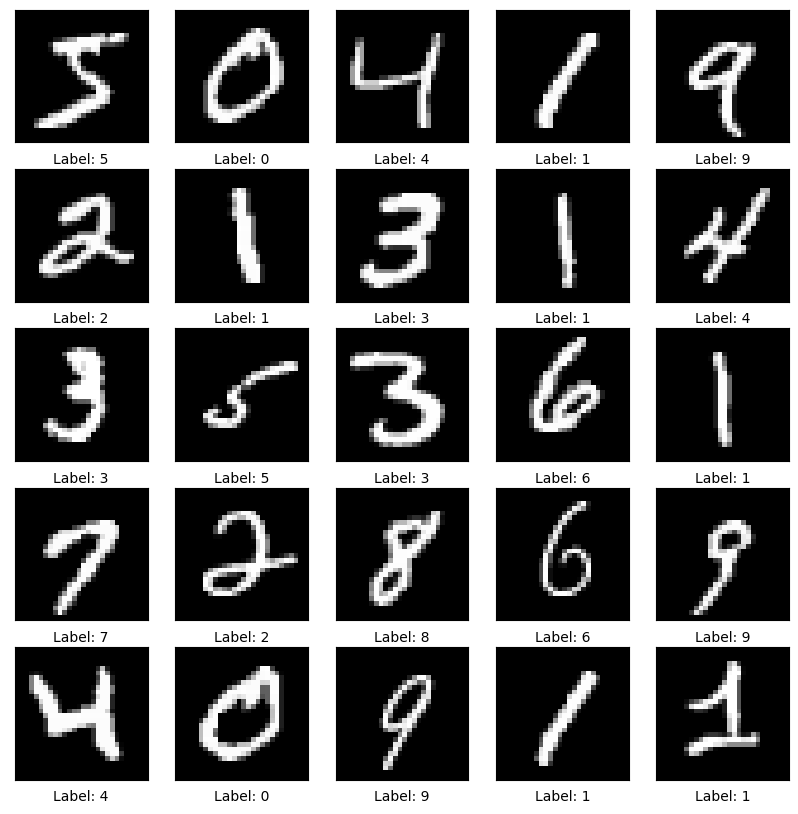

In [3]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images to have values between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

#Plot some of the images with their labels
plot_images(train_images, train_labels, num_images=25, figsize=(10,10))

In [4]:
# Expand the dimensions of the images to (28, 28, 1) to represent the grayscale channel explicitly
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

# Convert the labels to one-hot encoded vectors
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [5]:
class PatchExtractor(Layer):
    def __init__(self, patch_size=4):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [6]:
image = train_images[0]  # Select the first image of the dataset
batch = tf.expand_dims(image, 0)  # Adds the batch dimension 

# Now use PatchExtractor
patches = PatchExtractor(patch_size=4)(batch)

patches.shape

TensorShape([1, 49, 16])

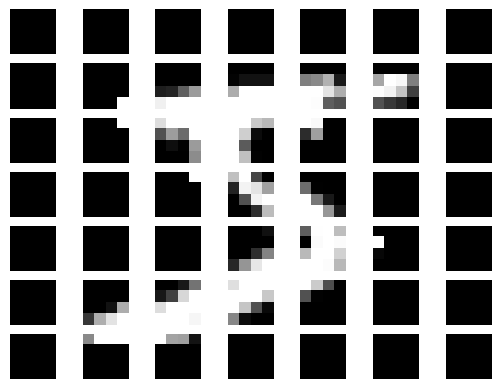

In [7]:
# Calculate the number of patches per side (sqrt) to organize the subplot grid
n = int(np.sqrt(patches.shape[1]))

# Visualize each patch
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    # Since the patch is flattened, we reshape it back to its original size (4x4 here), and there's only one channel for grayscale
    patch_img = tf.reshape(patch, (4, 4))
    ax.imshow(patch_img.numpy(), cmap='gray')
    ax.axis("off")

plt.show()

In [8]:
class PatchEncoder(Layer):
    def __init__(self, num_patches=49, projection_dim=4*4):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        w_init = tf.random_normal_initializer()
        self.class_token = tf.Variable(initial_value=w_init(shape=(1, projection_dim), dtype="float32"), trainable=True)
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches + 1, output_dim=projection_dim)

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        # Reshape the class token embeddings to be repeated for each item in the batch
        class_token = tf.tile(self.class_token, multiples=[batch_size, 1])
        class_token = tf.reshape(class_token, (batch_size, 1, self.projection_dim))
        # Calculate patches embeddings
        patches_embed = self.projection(patches)
        # Concatenate the class token with patch embeddings
        patches_embed = tf.concat([class_token, patches_embed], axis=1)
        # Calculate positional embeddings
        positions = tf.range(start=0, limit=self.num_patches + 1, delta=1)
        positions_embed = self.position_embedding(positions)
        # Add positional embeddings to the patch embeddings
        encoded = patches_embed + positions_embed
        return encoded

In [9]:
embeddings = PatchEncoder()(patches)
embeddings.shape

TensorShape([1, 50, 16])

In [11]:
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y
mlp = MLP(16 * 2, 16)
y = mlp(tf.zeros((1, 50, 16)))
y.shape

TensorShape([1, 50, 16])

In [12]:
class Block(Layer):
    def __init__(self, projection_dim, num_heads=4, dropout_rate=0.1):
        super(Block, self).__init__()
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        # Layer normalization 1.
        x1 = self.norm1(x) # encoded_patches
        # Create a multi-head attention layer.
        attention_output = self.attn(x1, x1)
        # Skip connection 1.
        x2 = Add()([attention_output, x]) #encoded_patches
        # Layer normalization 2.
        x3 = self.norm2(x2)
        # MLP.
        x3 = self.mlp(x3)
        # Skip connection 2.
        y = Add()([x3, x2])
        return y

block = Block(16)
y = block(tf.zeros((1, 50, 16)))
y.shape

TensorShape([1, 50, 16])

In [13]:
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_heads=4, num_blocks=3, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        self.norm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(0.1)

    def call(self, x):
        # Create a [batch_size, projection_dim] tensor.
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        y = self.dropout(x)
        return y
transformer = TransformerEncoder(16)
y = transformer(embeddings)
y.shape

TensorShape([1, 50, 16])

In [14]:
def create_VisionTransformer(num_classes, num_patches=49, projection_dim=16, input_shape=(28, 28, 1)):
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    logits = Dense(num_classes, activation='softmax')(representation)
    # Create model
    model = Model(inputs=inputs, outputs=logits)
    return model
model = create_VisionTransformer(10)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 patch_extractor_1 (PatchEx  (None, None, 16)          0         
 tractor)                                                        
                                                                 
 patch_encoder_1 (PatchEnco  (None, 50, 16)            1088      
 der)                                                            
                                                                 
 transformer_encoder_1 (Tra  (None, 50, 16)            16352     
 nsformerEncoder)                                                
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                     

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Default learning rate for Adam is 0.001
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_images, train_labels,
    epochs=20,  # The number of epochs to train for
    batch_size=32,  # The batch size to use during training
    validation_data=(test_images, test_labels)  # Data on which to evaluate the loss and any model metrics at the end of each epoch
)

Epoch 1/20


1875/1875 [==============================] - 71s 35ms/step - loss: 0.8372 - accuracy: 0.7104 - val_loss: 0.4796 - val_accuracy: 0.8481
Epoch 2/20
1875/1875 [==============================] - 71s 38ms/step - loss: 0.3826 - accuracy: 0.8757 - val_loss: 0.2971 - val_accuracy: 0.9083
Epoch 3/20
1875/1875 [==============================] - 67s 36ms/step - loss: 0.2818 - accuracy: 0.9103 - val_loss: 0.2072 - val_accuracy: 0.9359
Epoch 4/20
1875/1875 [==============================] - 71s 38ms/step - loss: 0.2265 - accuracy: 0.9288 - val_loss: 0.1699 - val_accuracy: 0.9475
Epoch 5/20
1875/1875 [==============================] - 66s 35ms/step - loss: 0.1912 - accuracy: 0.9401 - val_loss: 0.1702 - val_accuracy: 0.9499
Epoch 6/20
1875/1875 [==============================] - 68s 36ms/step - loss: 0.1717 - accuracy: 0.9461 - val_loss: 0.1413 - val_accuracy: 0.9565
Epoch 7/20
1875/1875 [==============================] - 67s 36ms/step - loss: 0.1577 - accuracy: 0.9507 - val_loss: 0.1221

In [17]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

313/313 [==============================] - 4s 14ms/step - loss: 0.0972 - accuracy: 0.9686
Test Loss: 0.09719765931367874
Test Accuracy: 0.9685999751091003


In [19]:
#model.save('model_TASKVIII.h5')  # Saves the model to a single HDF5 file.